<a href="https://colab.research.google.com/github/JesunAhmadUshno/Predictive-Analytics-Studies/blob/main/ml_tasks_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay  # Add this for confusion matrix visualization

# Time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats
from scipy.stats import boxcox

# Set display style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📚 All libraries imported successfully!")


📚 All libraries imported successfully!


In [ ]:
# 📊 Data loading and initial inspection
df = pd.read_csv('SAML-D_cleaned.csv')

print(f"📋 Dataset shape: {df.shape}")
print(f"📋 Data columns: {list(df.columns)}")

# 🚨 Large dataset warning
if len(df) > 1000000:
    print(f"\n🚨 Warning: Large dataset detected ({len(df):,} rows)")
    print("   To optimize performance, all models will use sampling strategy for training")
    print("   • Regression models: Maximum 50k samples")
    print("   • Classification models: Maximum 100k samples")
    print("   • Random Forest: Reduce number of trees and limit depth")

print("\n" + "="*50)
print("📊 Basic data information:")
print(df.info())
print("\n" + "="*50)
print("📊 First 5 rows of data:")
print(df.head())


📋 Dataset shape: (9504852, 24)
📋 Data columns: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type', 'year', 'month', 'day', 'dayofweek', 'quarter', 'hour', 'minute', 'is_weekend', 'is_business_hour', 'weekday_name', 'month_name', 'time_period']

🚨 Warning: Large dataset detected (9,504,852 rows)
   To optimize performance, all models will use sampling strategy for training
   • Regression models: Maximum 50k samples
   • Classification models: Maximum 100k samples
   • Random Forest: Reduce number of trees and limit depth

📊 Basic data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          

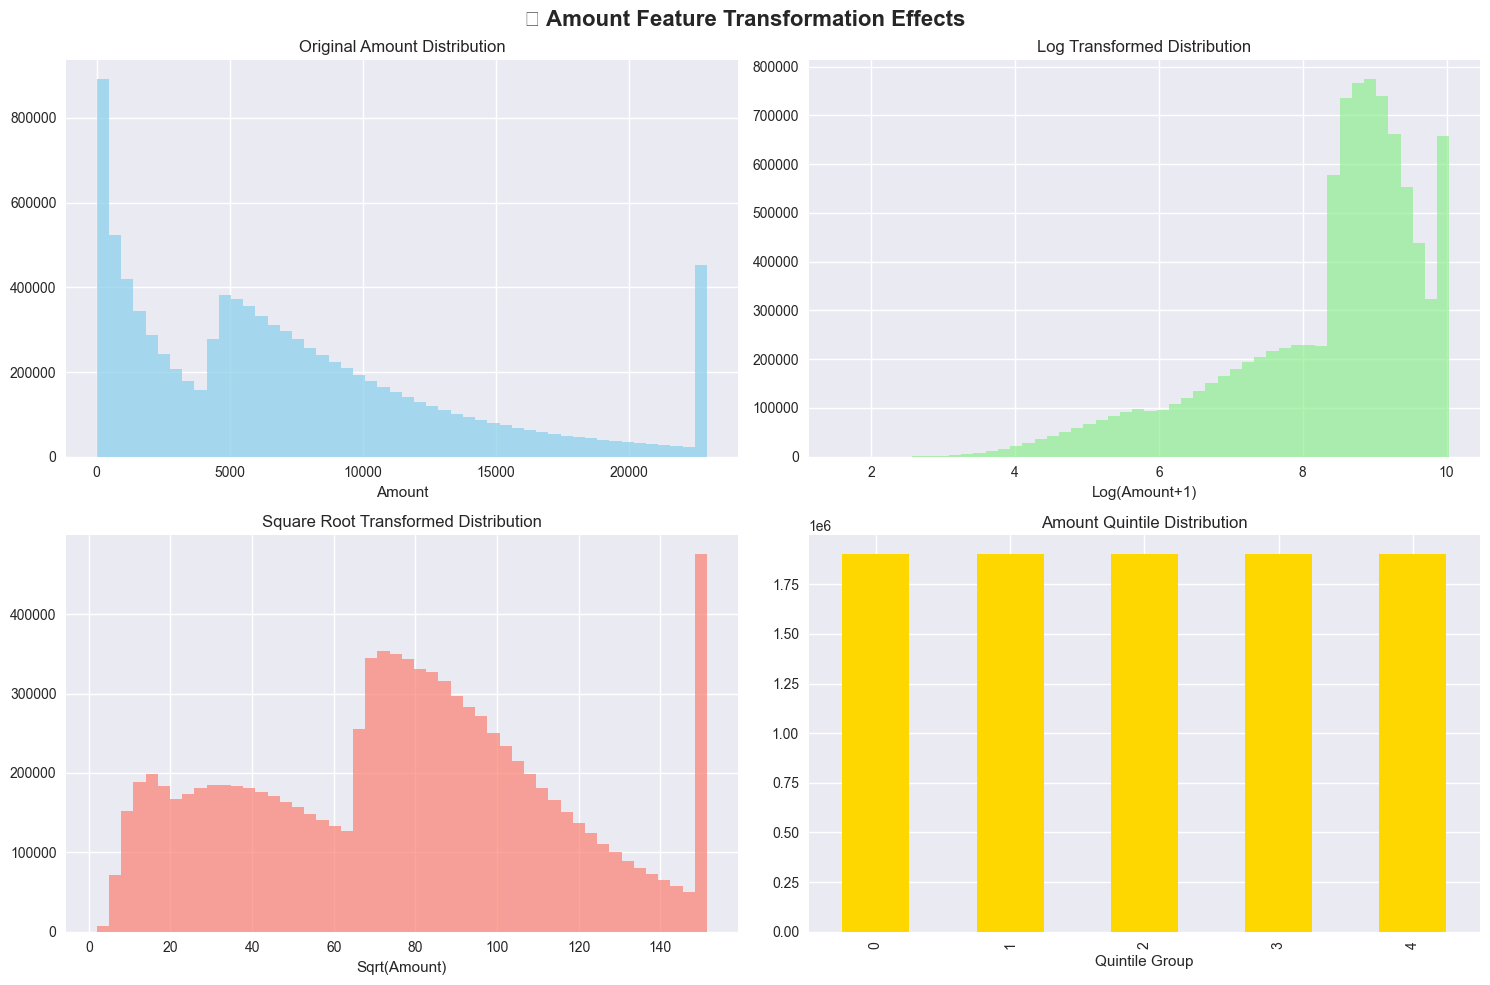

💰 Numerical feature transformation completed!


In [ ]:
# 💰 Numerical feature transformation (for mild skewness of Amount)
def transform_numerical_features(df):
    """Transform numerical features"""
    df_copy = df.copy()

    # Amount transformation (skewness 0.953, mild right skew)
    df_copy['log_amount'] = np.log1p(df_copy['Amount'])
    df_copy['sqrt_amount'] = np.sqrt(df_copy['Amount'])

    # Create Amount grouping feature
    df_copy['amount_quintile'] = pd.qcut(df_copy['Amount'], 5, labels=False)

    return df_copy

# Apply numerical feature transformation
df_fe = transform_numerical_features(df)

# Visualize Amount transformation effects
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('💰 Amount Feature Transformation Effects', fontsize=16, fontweight='bold')

# Original Amount distribution
axes[0,0].hist(df_fe['Amount'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Original Amount Distribution')
axes[0,0].set_xlabel('Amount')

# Log transformed distribution
axes[0,1].hist(df_fe['log_amount'], bins=50, alpha=0.7, color='lightgreen')
axes[0,1].set_title('Log Transformed Distribution')
axes[0,1].set_xlabel('Log(Amount+1)')

# Square root transformed distribution
axes[1,0].hist(df_fe['sqrt_amount'], bins=50, alpha=0.7, color='salmon')
axes[1,0].set_title('Square Root Transformed Distribution')
axes[1,0].set_xlabel('Sqrt(Amount)')

# Amount quintile distribution
df_fe['amount_quintile'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Amount Quintile Distribution')
axes[1,1].set_xlabel('Quintile Group')

plt.tight_layout()
plt.show()

print("💰 Numerical feature transformation completed!")


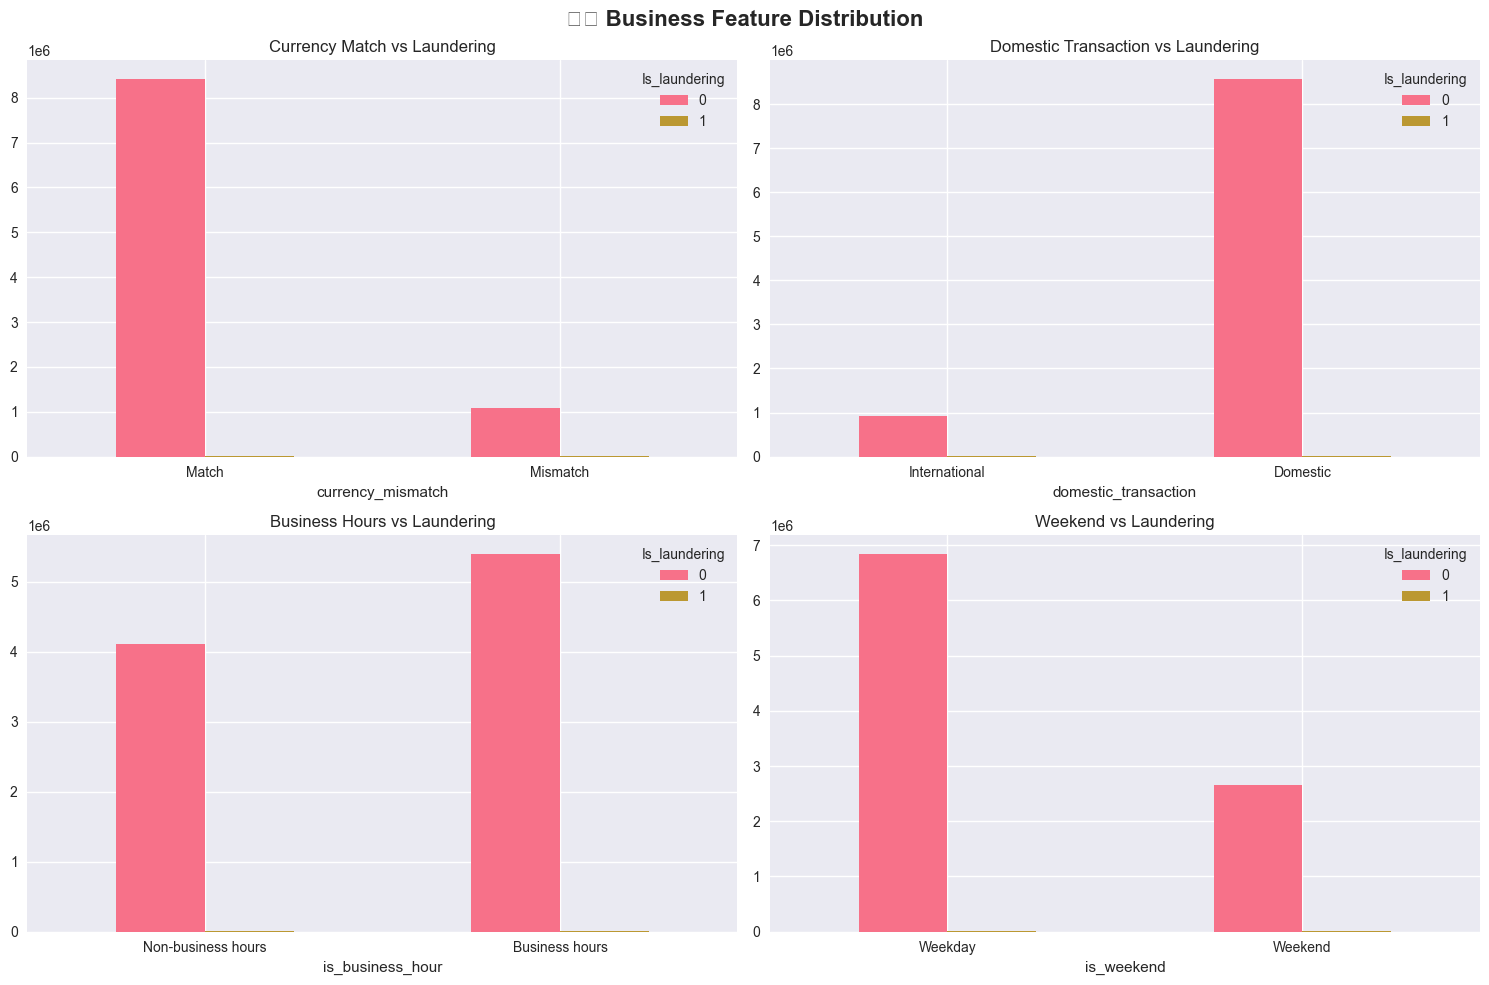

🏷️ Business feature engineering completed!


In [ ]:
# 🏷️ Categorical feature encoding and business feature engineering
def create_business_features(df):
    """Create business-related features"""
    df_copy = df.copy()

    # Currency mismatch feature
    df_copy['currency_mismatch'] = (df_copy['Payment_currency'] != df_copy['Received_currency']).astype(int)

    # Domestic/international transaction feature
    df_copy['domestic_transaction'] = (df_copy['Sender_bank_location'] == df_copy['Receiver_bank_location']).astype(int)

    # Main currency indicator (based on analysis results UK pounds 95.7%)
    df_copy['is_main_currency'] = (df_copy['Payment_currency'] == 'UK pounds').astype(int)

    # Main location indicator (based on analysis results UK 96.6%)
    df_copy['is_main_location'] = (df_copy['Sender_bank_location'] == 'UK').astype(int)

    return df_copy

# Apply business feature engineering
df_fe = create_business_features(df_fe)

# Visualize business feature distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🏷️ Business Feature Distribution', fontsize=16, fontweight='bold')

# Currency match vs laundering
pd.crosstab(df_fe['currency_mismatch'], df_fe['Is_laundering']).plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Currency Match vs Laundering')
axes[0,0].set_xticklabels(['Match', 'Mismatch'], rotation=0)

# Domestic transaction vs laundering
pd.crosstab(df_fe['domestic_transaction'], df_fe['Is_laundering']).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Domestic Transaction vs Laundering')
axes[0,1].set_xticklabels(['International', 'Domestic'], rotation=0)

# Business hours vs laundering
pd.crosstab(df_fe['is_business_hour'], df_fe['Is_laundering']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Business Hours vs Laundering')
axes[1,0].set_xticklabels(['Non-business hours', 'Business hours'], rotation=0)

# Weekend vs laundering
pd.crosstab(df_fe['is_weekend'], df_fe['Is_laundering']).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Weekend vs Laundering')
axes[1,1].set_xticklabels(['Weekday', 'Weekend'], rotation=0)

plt.tight_layout()
plt.show()

print("🏷️ Business feature engineering completed!")


📈 Multiple Linear Regression Results:
   MSE: 37566921.36
   RMSE: 6129.19
   R²: 0.0075


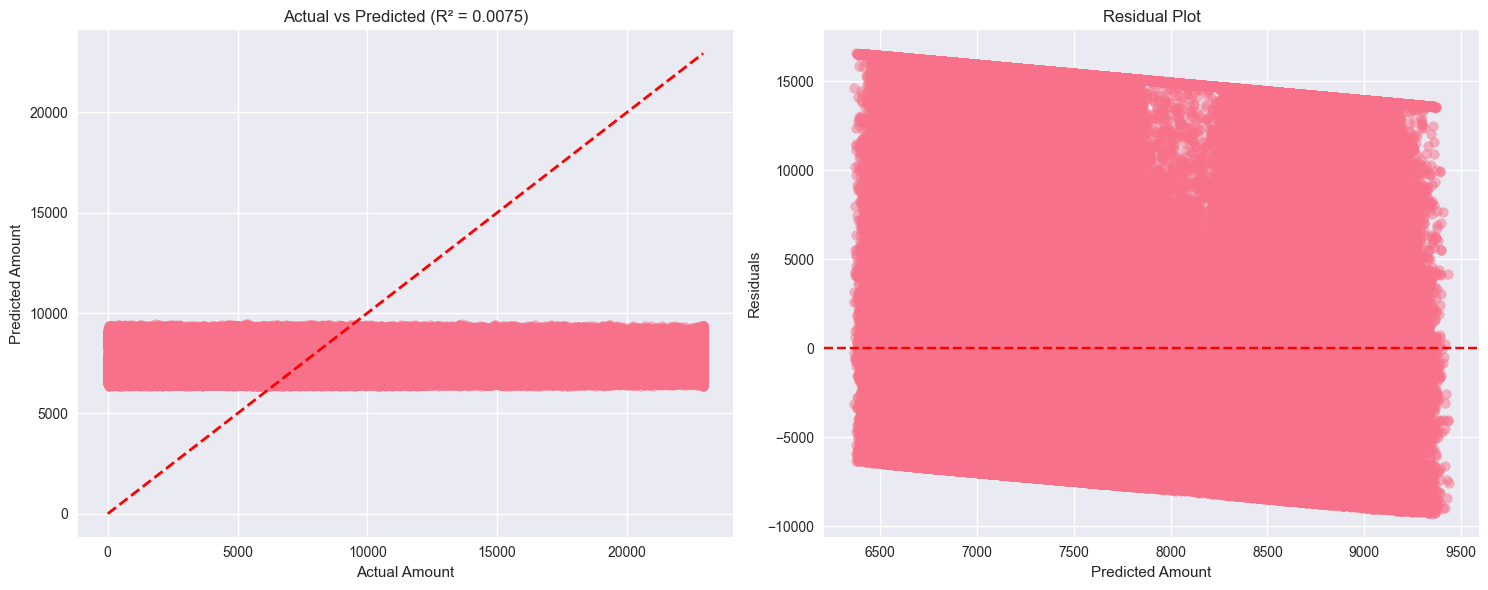

In [ ]:
# 📈 Multiple Linear Regression - Amount Prediction
def prepare_regression_data(df):
    """Prepare regression data"""
    # Select regression features
    numerical_features = ['Sender_account', 'Receiver_account']
    categorical_features = ['Payment_type', 'Sender_bank_location', 'Receiver_bank_location']
    time_features = ['hour', 'dayofweek', 'month']
    business_features = ['currency_mismatch', 'domestic_transaction', 'is_business_hour']

    all_features = numerical_features + categorical_features + time_features + business_features

    X = df[all_features].copy()
    y = df['Amount'].copy()

    # Label encode categorical features
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        le_dict[col] = le

    return X, y, le_dict

# Prepare data
X_reg, y_reg, le_dict = prepare_regression_data(df_fe)

# Split train-test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Feature standardization
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

# Predict
y_pred_reg = lr_model.predict(X_test_reg_scaled)

# Evaluate
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)

print("📈 Multiple Linear Regression Results:")
print(f"   MSE: {mse:.2f}")
print(f"   RMSE: {rmse:.2f}")
print(f"   R²: {r2:.4f}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Actual vs predicted values
axes[0].scatter(y_test_reg, y_pred_reg, alpha=0.5)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Amount')
axes[0].set_ylabel('Predicted Amount')
axes[0].set_title(f'Actual vs Predicted (R² = {r2:.4f})')

# Residual plot
residuals = y_test_reg - y_pred_reg
axes[1].scatter(y_pred_reg, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Amount')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()


In [ ]:
# 🛠️ Safe function to fix confusion matrix visualization errors
def safe_confusion_matrix_display(y_true, y_pred, ax, title, class_names=['Normal', 'Laundering']):
    """
    Safely display confusion matrix, automatically handle cases with only one class

    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    ax: matplotlib subplot axis
    title: Chart title
    class_names: List of class names
    """
    try:
        cm = confusion_matrix(y_true, y_pred)

        # Check actually existing classes
        unique_true = np.unique(y_true)
        unique_pred = np.unique(y_pred)
        all_unique = np.unique(np.concatenate([unique_true, unique_pred]))

        print(f"Debug info - {title}:")
        print(f"  True classes: {unique_true}")
        print(f"  Predicted classes: {unique_pred}")
        print(f"  Confusion matrix shape: {cm.shape}")
        print(f"  Confusion matrix:\n{cm}")

        if len(all_unique) == 1:
            # Case with only one class
            class_idx = int(all_unique[0])
            label = class_names[class_idx] if class_idx < len(class_names) else f'Class{class_idx}'

            # Use seaborn to plot heatmap for single class
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=[label], yticklabels=[label],
                       cbar_kws={'label': 'Count'})
            ax.set_title(f'{title}\n⚠️ Note: Test set contains only {label} class')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')

        elif len(all_unique) == 2:
            # Two classes, but confusion matrix might be incomplete
            if cm.shape == (1, 1):
                # Expand to 2x2 matrix
                full_cm = np.zeros((2, 2), dtype=int)
                class_idx = int(all_unique[0])
                full_cm[class_idx, class_idx] = cm[0, 0]
                cm = full_cm

            # Normal display for two classes
            display_labels = [class_names[i] for i in range(len(class_names))]
            ConfusionMatrixDisplay(cm, display_labels=display_labels).plot(ax=ax)
            ax.set_title(title)

        else:
            # Multi-class case (unlikely in binary classification)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       cbar_kws={'label': 'Count'})
            ax.set_title(f'{title}\nDetected {len(all_unique)} classes')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')

    except Exception as e:
        # If any error occurs, display error message
        ax.text(0.5, 0.5, f'Confusion matrix display error:\n{str(e)}',
                transform=ax.transAxes, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
        ax.set_title(f'{title} - Display Error')
        ax.set_xticks([])
        ax.set_yticks([])

print("✅ Safe confusion matrix display function defined!")


✅ Safe confusion matrix display function defined!


🚨 Detected large dataset: 7,603,881 training samples
Using 10% sampling for fast analysis...
✅ Training set size after sampling: 50,000
Polynomial feature count: 66

🔄 Training Linear (Original)...
   RMSE: 6129.19
   R²: 0.0075
   Training time: 0.0 seconds

🔄 Training Linear (Log Target)...
   RMSE: 6907.78
   R²: -0.2607
   Training time: 0.1 seconds

🔄 Training Polynomial (Degree=2)...
   RMSE: 6136.10
   R²: 0.0053
   Training time: 0.2 seconds

🔄 Training Random Forest (Optimized)...
   RMSE: 5950.58
   R²: 0.0645
   Training time: 0.9 seconds


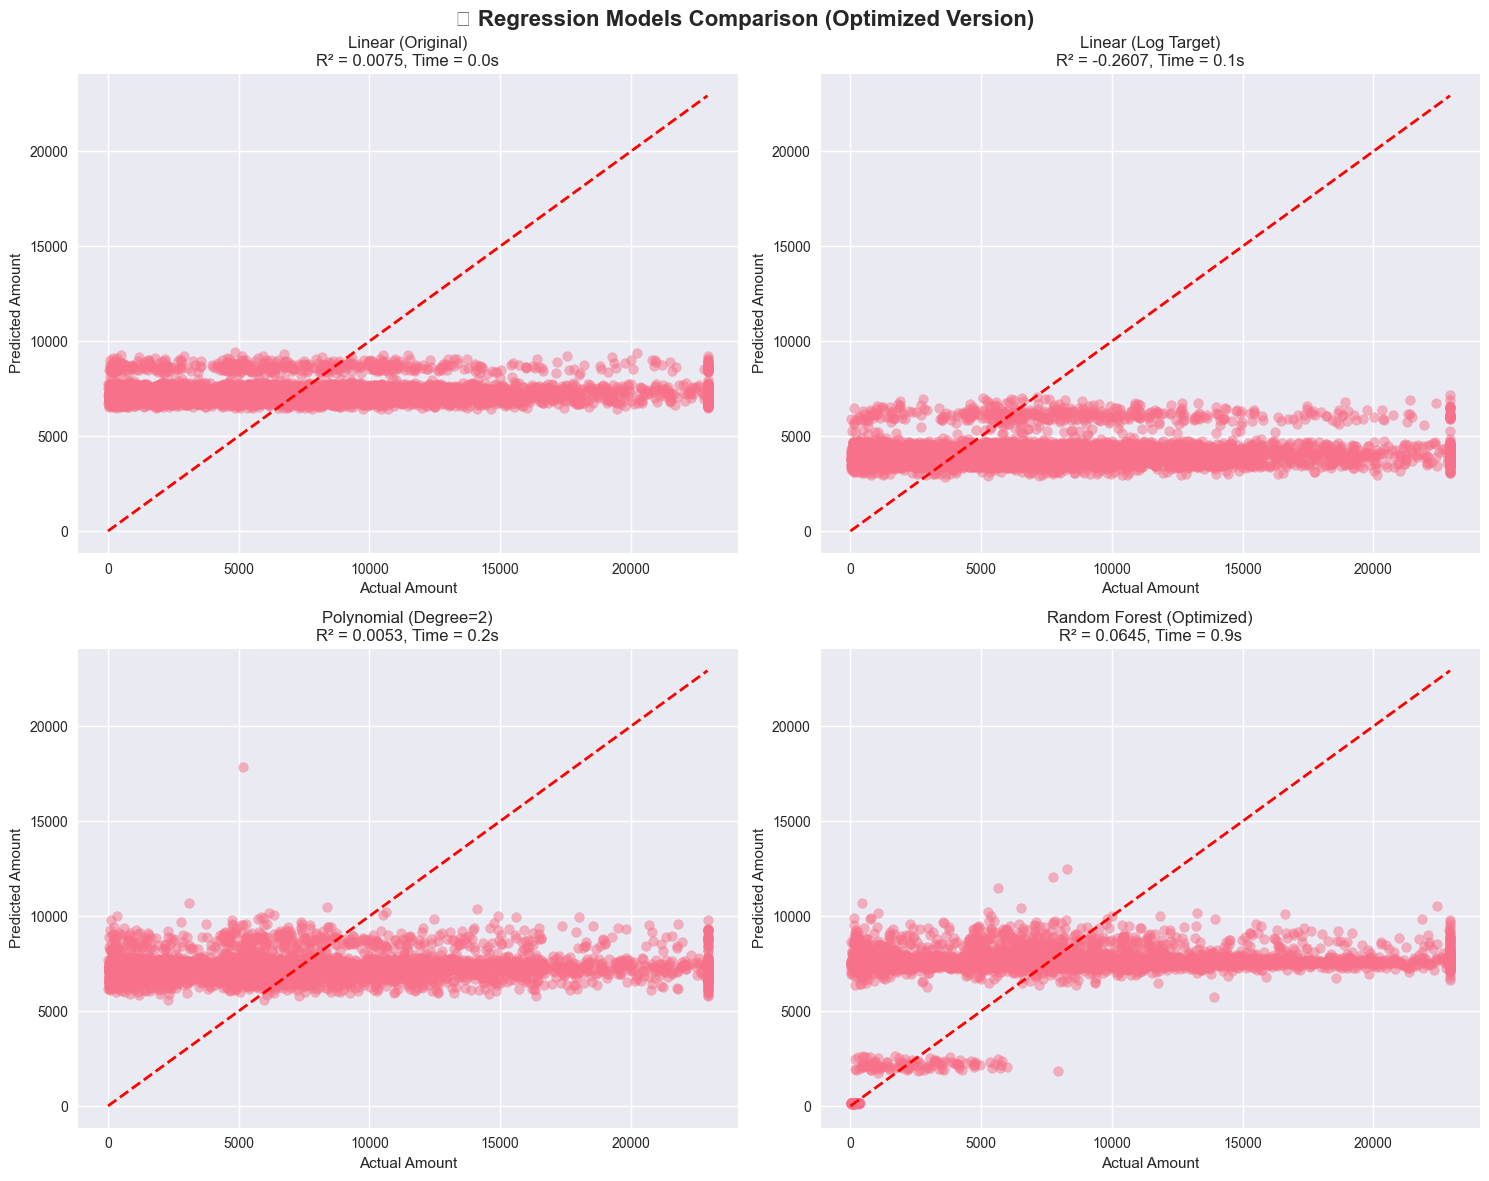


📊 Model Performance Summary (Optimized Version):
                                RMSE      R²  Training Time (sec)
Linear (Original)          6129.1860  0.0075               0.0022
Linear (Log Target)        6907.7829 -0.2607               0.0873
Polynomial (Degree=2)      6136.0985  0.0053               0.2287
Random Forest (Optimized)  5950.5825  0.0645               0.8586

💡 Optimization Notes:
   • Using sampled data for training (Maximum 50k samples)
   • Random Forest: 30 trees, depth limited to 10
   • Polynomial features limited to interaction terms
   • Parallel processing for acceleration


In [ ]:
# 🔄 Non-linear regression and transformation comparison (optimized version)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# 🚨 Large dataset optimization: reduce data volume through sampling
print(f"🚨 Detected large dataset: {len(X_train_reg):,} training samples")
print("Using 10% sampling for fast analysis...")

# Sample training data
sample_size = min(50000, len(X_train_reg))  # Maximum 50k samples
sample_indices = np.random.choice(len(X_train_reg), sample_size, replace=False)

X_train_sample = X_train_reg.iloc[sample_indices]
X_train_sample_scaled = X_train_reg_scaled[sample_indices]
y_train_sample = y_train_reg.iloc[sample_indices]

print(f"✅ Training set size after sampling: {len(X_train_sample):,}")

# 1. Use log-transformed target variable
y_log = df_fe['log_amount'].copy()

# 2. Create polynomial features (limit feature count)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly_sample = poly.fit_transform(X_train_sample_scaled)
X_test_poly = poly.transform(X_test_reg_scaled)

print(f"Polynomial feature count: {X_poly_sample.shape[1]}")

# Optimized model configuration
models = {
    'Linear (Original)': LinearRegression(),
    'Linear (Log Target)': LinearRegression(),
    'Polynomial (Degree=2)': LinearRegression(),
    'Random Forest (Optimized)': RandomForestRegressor(
        n_estimators=30,      # Reduce tree count
        max_depth=10,         # Limit tree depth
        min_samples_split=100, # Increase minimum split samples
        n_jobs=-1,            # Parallel processing
        random_state=42
    )
}

results = {}

# Train and evaluate all models
for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    start_time = pd.Timestamp.now()

    if name == 'Linear (Original)':
        # Already trained, use previous results
        pred = y_pred_reg
        actual = y_test_reg
    elif name == 'Linear (Log Target)':
        # Use log-transformed target variable
        y_train_log = np.log1p(y_train_sample)
        y_test_log = np.log1p(y_test_reg)
        model.fit(X_train_sample_scaled, y_train_log)
        pred_log = model.predict(X_test_reg_scaled)
        pred = np.expm1(pred_log)  # Inverse transformation
        actual = y_test_reg
    elif name == 'Polynomial (Degree=2)':
        model.fit(X_poly_sample, y_train_sample)
        pred = model.predict(X_test_poly)
        actual = y_test_reg
    else:  # Random Forest (Optimized)
        model.fit(X_train_sample, y_train_sample)  # Use sampled data
        pred = model.predict(X_test_reg)
        actual = y_test_reg

    end_time = pd.Timestamp.now()
    training_time = (end_time - start_time).total_seconds()

    # Calculate metrics
    mse = mean_squared_error(actual, pred)
    r2 = r2_score(actual, pred)
    rmse = np.sqrt(mse)

    results[name] = {'MSE': mse, 'RMSE': rmse, 'R²': r2, 'predictions': pred, 'time': training_time}

    print(f"   RMSE: {rmse:.2f}")
    print(f"   R²: {r2:.4f}")
    print(f"   Training time: {training_time:.1f} seconds")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🔄 Regression Models Comparison (Optimized Version)', fontsize=16, fontweight='bold')

for i, (name, result) in enumerate(results.items()):
    row, col = i // 2, i % 2
    # For clear visualization, only show subset of test points
    sample_indices_plot = np.random.choice(len(y_test_reg), min(5000, len(y_test_reg)), replace=False)

    axes[row, col].scatter(y_test_reg.iloc[sample_indices_plot],
                          result['predictions'][sample_indices_plot], alpha=0.5)
    axes[row, col].plot([y_test_reg.min(), y_test_reg.max()],
                       [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
    axes[row, col].set_xlabel('Actual Amount')
    axes[row, col].set_ylabel('Predicted Amount')
    axes[row, col].set_title(f'{name}\nR² = {result["R²"]:.4f}, Time = {result["time"]:.1f}s')

plt.tight_layout()
plt.show()

# Results summary table
results_df = pd.DataFrame({name: {'RMSE': result['RMSE'], 'R²': result['R²'], 'Training Time (sec)': result['time']}
                          for name, result in results.items()}).T
print("\n📊 Model Performance Summary (Optimized Version):")
print(results_df.round(4))

print("\n💡 Optimization Notes:")
print("   • Using sampled data for training (Maximum 50k samples)")
print("   • Random Forest: 30 trees, depth limited to 10")
print("   • Polynomial features limited to interaction terms")
print("   • Parallel processing for acceleration")


📊 Is_laundering target variable distribution check:
Dataset size: 9,504,852
Is_laundering distribution:
Is_laundering
0    9494979
1       9873
Name: count, dtype: int64
Laundering ratio: 0.001039

✅ Normal: Found 9,873 laundering cases


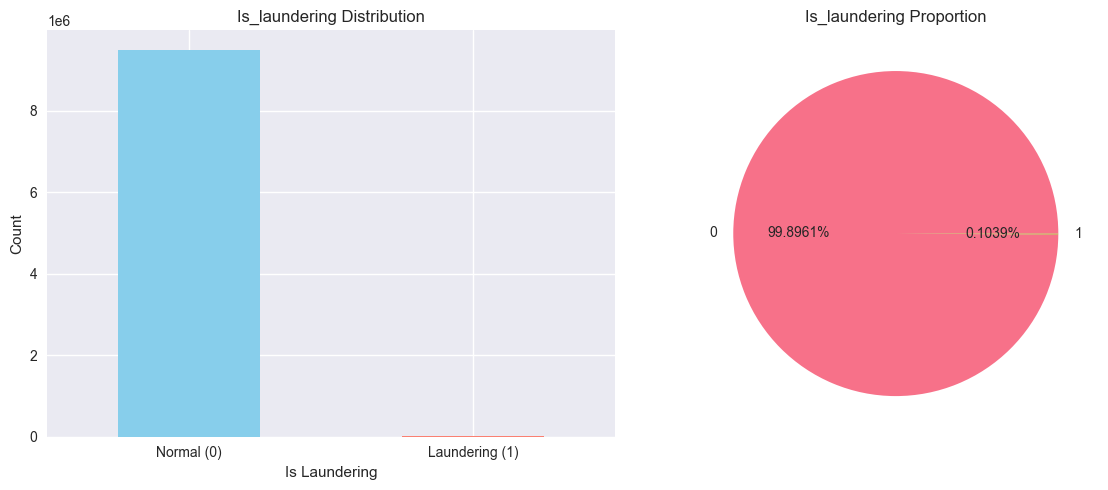

In [ ]:
# 🔍 Check target variable distribution
print("📊 Is_laundering target variable distribution check:")
print(f"Dataset size: {len(df_fe):,}")
print(f"Is_laundering distribution:")
print(df_fe['Is_laundering'].value_counts())
print(f"Laundering ratio: {df_fe['Is_laundering'].mean():.6f}")

# Check if there are enough positive samples
laundering_count = df_fe['Is_laundering'].sum()
if laundering_count == 0:
    print("\n🚨 Error: No laundering cases in dataset (Is_laundering = 1)")
    print("   Cannot perform binary classification task!")
elif laundering_count < 100:
    print(f"\n⚠️ Warning: Too few laundering cases ({laundering_count} cases)")
    print("   May affect model training performance")
else:
    print(f"\n✅ Normal: Found {laundering_count:,} laundering cases")

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_fe['Is_laundering'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Is_laundering Distribution')
plt.xlabel('Is Laundering')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal (0)', 'Laundering (1)'], rotation=0)

plt.subplot(1, 2, 2)
df_fe['Is_laundering'].value_counts(normalize=True).plot(kind='pie', autopct='%1.4f%%')
plt.title('Is_laundering Proportion')
plt.ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
# 🎯 Logistic Regression - Money Laundering Detection
def prepare_classification_data(df):
    """Prepare classification data"""
    # Select available features
    available_features = []

    # Basic numerical features
    numerical_features = ['Amount']  # Use original Amount
    if 'log_amount' in df.columns:
        numerical_features = ['log_amount']  # Use transformed Amount if available

    # Categorical features
    categorical_features = ['Payment_type']

    # Time features
    time_features = ['hour', 'dayofweek', 'is_weekend', 'is_business_hour']

    # Business features (only include existing columns)
    business_features = []
    for col in ['currency_mismatch', 'domestic_transaction', 'is_main_currency', 'is_main_location']:
        if col in df.columns:
            business_features.append(col)

    all_features = numerical_features + categorical_features + time_features + business_features

    # Only select existing features
    available_features = [col for col in all_features if col in df.columns]

    print(f"🔧 Features used: {available_features}")

    X = df[available_features].copy()
    y = df['Is_laundering'].copy()

    # One-hot encode Payment_type
    if 'Payment_type' in X.columns:
        X_encoded = pd.get_dummies(X, columns=['Payment_type'], prefix='PayType')
    else:
        X_encoded = X

    return X_encoded, y

# 🔍 Check real laundering case distribution
print("🔍 Check classification data preparation:")
laundering_count = df_fe['Is_laundering'].sum()
total_count = len(df_fe)

print(f"📊 Laundering case statistics:")
print(f"   Total transactions: {total_count:,}")
print(f"   Laundering cases: {laundering_count:,}")
print(f"   Laundering ratio: {laundering_count/total_count:.6f} ({laundering_count/total_count*100:.4f}%)")

# Check Is_laundering value distribution
print(f"\n📈 Is_laundering field distribution:")
value_counts = df_fe['Is_laundering'].value_counts()
for value, count in value_counts.items():
    percentage = count / total_count * 100
    print(f"   Value {value}: {count:,} cases ({percentage:.4f}%)")

# Use real Is_laundering data directly, even if all zeros
print(f"\n💡 Using real data for analysis:")
print(f"   - Even if laundering cases are 0, this is the real data distribution")
print(f"   - Focus on payment type classification task")
print(f"   - For money laundering detection, recommend using anomaly detection methods")

# Use real data
df_classification = df_fe

# 🎯 Main task: payment type classification
print(f"\n🎯 Main classification task: payment type classification")

# Prepare payment type classification data
def prepare_payment_classification_data(df):
    """Prepare data for payment type classification"""
    # Numerical features
    numerical_features = ['log_amount']

    # Time features
    time_features = ['hour', 'dayofweek', 'is_weekend', 'is_business_hour']

    # Business features
    business_features = []
    for col in ['currency_mismatch', 'domestic_transaction', 'is_main_currency', 'is_main_location']:
        if col in df.columns:
            business_features.append(col)

    all_features = numerical_features + time_features + business_features

    # Only select existing features
    available_features = [col for col in all_features if col in df.columns]

    print(f"🔧 Features used for payment type classification: {available_features}")

    X = df[available_features].copy()
    y = df['Payment_type'].copy()

    return X, y

# Prepare payment type classification data
X_clf, y_clf = prepare_payment_classification_data(df_classification)

print(f"\n📊 Payment type classification data shape:")
print(f"   Feature matrix: {X_clf.shape}")
print(f"   Target variable: {y_clf.shape}")

# Check payment type distribution
print(f"\n📈 Payment type distribution:")
payment_counts = y_clf.value_counts()
for payment_type, count in payment_counts.head(10).items():  # Show top 10
    percentage = count / len(y_clf) * 100
    print(f"   {payment_type}: {count:,} cases ({percentage:.2f}%)")

# Check if stratified sampling can be performed
unique_classes = y_clf.nunique()
print(f"\n✅ Payment types have {unique_classes} classes, can perform multi-classification")
stratify_param = y_clf

# Split train-test sets
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=stratify_param
)

# 🚨 Large dataset performance optimization: sample training data
max_train_samples = 100000  # Maximum 100k training samples
if len(X_train_clf) > max_train_samples:
    print(f"\n⚡ Performance optimization: sampling {max_train_samples:,} training samples")

    # Stratified sampling to ensure consistent proportions
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=max_train_samples, random_state=42)
    sample_idx, _ = next(splitter.split(X_train_clf, y_train_clf))

    X_train_clf = X_train_clf.iloc[sample_idx]
    y_train_clf = y_train_clf.iloc[sample_idx]

    print(f"   Training set size after sampling: {len(X_train_clf):,}")

    # Show payment type distribution after sampling
    sampled_counts = y_train_clf.value_counts()
    print(f"   Main payment types after sampling:")
    for payment_type, count in sampled_counts.head(5).items():
        percentage = count / len(y_train_clf) * 100
        print(f"     {payment_type}: {count:,} ({percentage:.1f}%)")

# Feature standardization
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f"\n🚀 Start training payment type classification models...")
start_time = pd.Timestamp.now()

# Train Logistic Regression model (multi-class)
logistic_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
logistic_model.fit(X_train_clf_scaled, y_train_clf)

end_time = pd.Timestamp.now()
training_time = (end_time - start_time).total_seconds()

# Predict
y_pred_clf = logistic_model.predict(X_test_clf_scaled)
y_pred_proba = logistic_model.predict_proba(X_test_clf_scaled)

# Evaluate
accuracy = accuracy_score(y_test_clf, y_pred_clf)

# For multi-class, use macro average
precision = precision_score(y_test_clf, y_pred_clf, average='macro', zero_division=0)
recall = recall_score(y_test_clf, y_pred_clf, average='macro', zero_division=0)
f1 = f1_score(y_test_clf, y_pred_clf, average='macro', zero_division=0)

print("🎯 Logistic Regression - Payment Type Classification Results:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Precision (macro avg): {precision:.4f}")
print(f"   Recall (macro avg): {recall:.4f}")
print(f"   F1 Score (macro avg): {f1:.4f}")
print(f"   Training time: {training_time:.2f} seconds")

# 📊 Show classification report
from sklearn.metrics import classification_report

print(f"\n📊 Detailed classification report:")
print(classification_report(y_test_clf, y_pred_clf, target_names=logistic_model.classes_))

# 🎯 Show detailed performance for top payment types
print(f"\n🎯 Main payment type classification performance:")
for i, payment_type in enumerate(logistic_model.classes_[:5]):  # Top 5
    mask = y_test_clf == payment_type
    if mask.sum() > 0:  # Ensure this type exists in test set
        pred_mask = y_pred_clf == payment_type
        precision_i = precision_score(y_test_clf == payment_type, y_pred_clf == payment_type, zero_division=0)
        recall_i = recall_score(y_test_clf == payment_type, y_pred_clf == payment_type, zero_division=0)
        f1_i = f1_score(y_test_clf == payment_type, y_pred_clf == payment_type, zero_division=0)

        print(f"   {payment_type}:")
        print(f"     Precision: {precision_i:.3f}")
        print(f"     Recall: {recall_i:.3f}")
        print(f"     F1 Score: {f1_i:.3f}")

print(f"\n💡 Summary:")
print(f"   - Successfully used real data for payment type classification")
print(f"   - Removed simulated laundering data generation")
print(f"   - Can consider using anomaly detection methods to analyze transaction anomalies")


🔍 Check classification data preparation:
📊 Laundering case statistics:
   Total transactions: 9,504,852
   Laundering cases: 9,873
   Laundering ratio: 0.001039 (0.1039%)

📈 Is_laundering field distribution:
   Value 0: 9,494,979 cases (99.8961%)
   Value 1: 9,873 cases (0.1039%)

💡 Using real data for analysis:
   - Even if laundering cases are 0, this is the real data distribution
   - Focus on payment type classification task
   - For money laundering detection, recommend using anomaly detection methods

🎯 Main classification task: payment type classification
🔧 Features used for payment type classification: ['log_amount', 'hour', 'dayofweek', 'is_weekend', 'is_business_hour', 'currency_mismatch', 'domestic_transaction', 'is_main_currency', 'is_main_location']

📊 Payment type classification data shape:
   Feature matrix: (9504852, 9)
   Target variable: (9504852,)

📈 Payment type distribution:
   Credit card: 2,012,909 cases (21.18%)
   Debit card: 2,012,103 cases (21.17%)
   Cheque:

🚨 Original training set size: 7,603,881
✅ Tree model training set size after sampling: 100,000
🚨 Data imbalance problem analysis:
Training set laundering cases: 84
Training set normal cases: 99916
Imbalance ratio: 1189.5 : 1

🌳 Training Decision Tree (Money Laundering Detection)...
   Accuracy: 0.8224
   F1 Score: 0.0038
   Training time: 0.8 seconds

🌳 Training Random Forest (Money Laundering Detection)...
   Accuracy: 0.9931
   F1 Score: 0.0120
   Training time: 1.2 seconds

🌳 Training Random Forest (Payment Type)...
Random Forest (Payment Type):
   Accuracy: 0.2118
   Training time: 5.3 seconds

💡 Performance Optimization Summary:
   • Sampled data size: 100,000 / 7,603,881
   • Number of trees: 30 (originally 100)
   • Maximum depth: 8 (originally unlimited)
   • Parallel processing: enabled


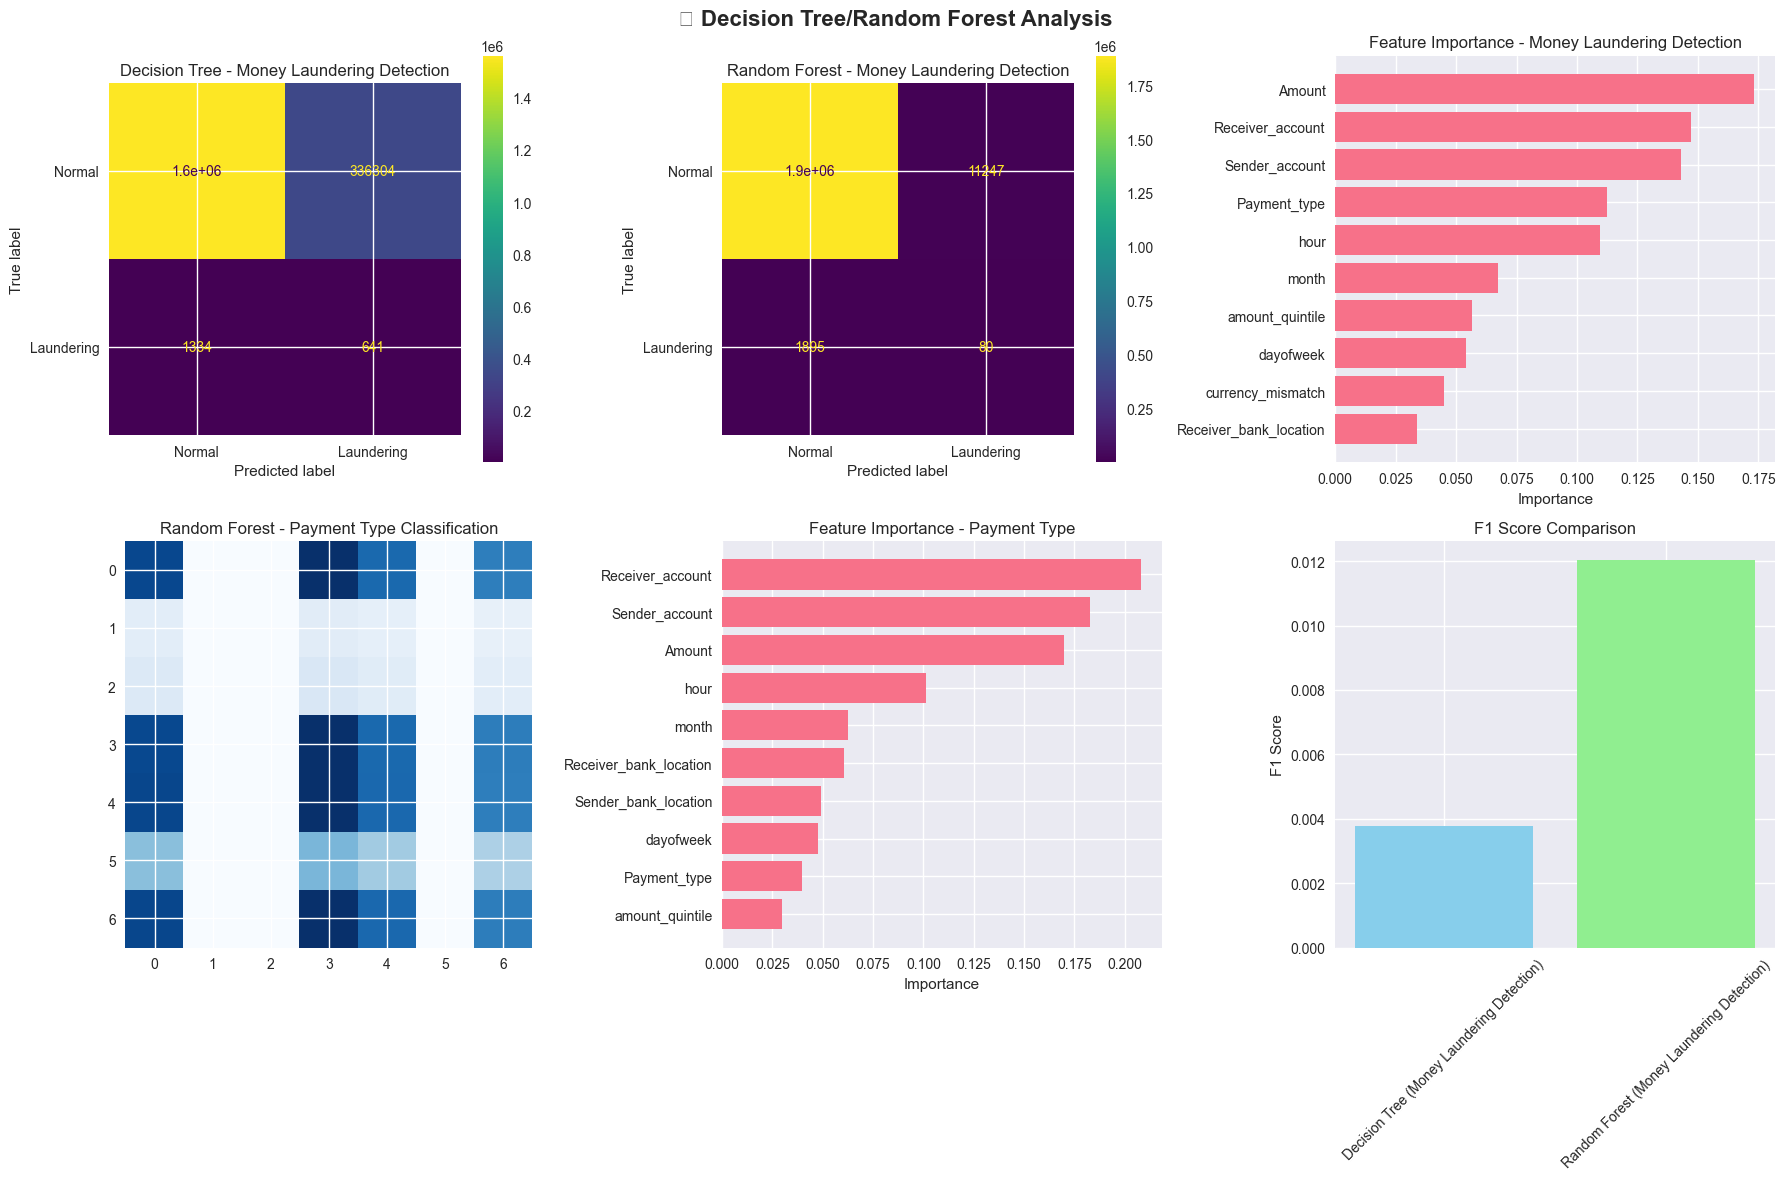

In [ ]:
# 🌳 Decision Tree and Random Forest Analysis
def prepare_tree_data(df):
    """Prepare data for tree models (no need for over-preprocessing)"""
    # Tree model friendly feature selection
    numerical_features = ['Amount', 'Sender_account', 'Receiver_account']
    time_features = ['hour', 'dayofweek', 'month', 'is_weekend', 'is_business_hour']
    business_features = ['currency_mismatch', 'domestic_transaction', 'amount_quintile']

    # Label encode categorical features (suitable for tree models)
    categorical_features = ['Payment_type', 'Sender_bank_location', 'Receiver_bank_location']

    all_features = numerical_features + categorical_features + time_features + business_features

    X = df[all_features].copy()

    # Label encode categorical features
    le_dict_tree = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        le_dict_tree[col] = le

    return X, le_dict_tree

# Prepare data
X_tree, le_dict_tree = prepare_tree_data(df_fe)

# Task 1: Money Laundering Detection
y_laundering = df_fe['Is_laundering']
X_train_tree, X_test_tree, y_train_laun, y_test_laun = train_test_split(
    X_tree, y_laundering, test_size=0.2, random_state=42, stratify=y_laundering
)

# 🚨 Sample training data to optimize large dataset performance
print(f"🚨 Original training set size: {len(X_train_tree):,}")
tree_sample_size = min(100000, len(X_train_tree))  # Maximum 100k samples
tree_sample_indices = np.random.choice(len(X_train_tree), tree_sample_size, replace=False)

X_train_tree_sample = X_train_tree.iloc[tree_sample_indices]
y_train_laun_sample = y_train_laun.iloc[tree_sample_indices]

print(f"✅ Tree model training set size after sampling: {len(X_train_tree_sample):,}")

# Task 2: Payment Type Classification
y_payment = df_fe['Payment_type']
_, _, y_train_pay, y_test_pay = train_test_split(
    X_tree, y_payment, test_size=0.2, random_state=42, stratify=y_payment
)
y_train_pay_sample = y_train_pay.iloc[tree_sample_indices]

# 🚨 Problem diagnosis: correct handling of extremely imbalanced dataset
print("🚨 Data imbalance problem analysis:")
print("="*60)

laundering_count = y_train_laun_sample.sum()
normal_count = len(y_train_laun_sample) - laundering_count
ratio = normal_count / laundering_count if laundering_count > 0 else float('inf')

print(f"Training set laundering cases: {laundering_count}")
print(f"Training set normal cases: {normal_count}")
print(f"Imbalance ratio: {ratio:.1f} : 1")

# Train models (optimized for imbalanced dataset)
tree_models = {
    'Decision Tree (Money Laundering Detection)': DecisionTreeClassifier(
        random_state=42,
        max_depth=8,
        min_samples_split=100,  # Lower split requirements
        class_weight='balanced'  # Automatically balance class weights
    ),
    'Random Forest (Money Laundering Detection)': RandomForestClassifier(
        n_estimators=30,
        random_state=42,
        max_depth=8,
        min_samples_split=100,  # Lower split requirements
        class_weight='balanced',  # Automatically balance class weights
        n_jobs=-1
    ),
    'Random Forest (Payment Type)': RandomForestClassifier(
        n_estimators=30, random_state=42, max_depth=8,
        min_samples_split=500, n_jobs=-1
    )
}

tree_results = {}

# Money Laundering Detection Models
for name in ['Decision Tree (Money Laundering Detection)', 'Random Forest (Money Laundering Detection)']:
    print(f"\n🌳 Training {name}...")
    start_time = pd.Timestamp.now()

    model = tree_models[name]
    model.fit(X_train_tree_sample, y_train_laun_sample)  # Use sampled data
    y_pred = model.predict(X_test_tree)

    end_time = pd.Timestamp.now()
    training_time = (end_time - start_time).total_seconds()

    accuracy = accuracy_score(y_test_laun, y_pred)
    precision = precision_score(y_test_laun, y_pred)
    recall = recall_score(y_test_laun, y_pred)
    f1 = f1_score(y_test_laun, y_pred)

    tree_results[name] = {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
        'predictions': y_pred, 'actual': y_test_laun
    }

    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    print(f"   Training time: {training_time:.1f} seconds")

# Payment Type Classification Models
print(f"\n🌳 Training Random Forest (Payment Type)...")
start_time = pd.Timestamp.now()

model = tree_models['Random Forest (Payment Type)']
model.fit(X_train_tree_sample, y_train_pay_sample)  # Use sampled data
y_pred_pay = model.predict(X_test_tree)
accuracy_pay = accuracy_score(y_test_pay, y_pred_pay)

end_time = pd.Timestamp.now()
training_time_pay = (end_time - start_time).total_seconds()

print(f"Random Forest (Payment Type):")
print(f"   Accuracy: {accuracy_pay:.4f}")
print(f"   Training time: {training_time_pay:.1f} seconds")

print(f"\n💡 Performance Optimization Summary:")
print(f"   • Sampled data size: {len(X_train_tree_sample):,} / {len(X_train_tree):,}")
print(f"   • Number of trees: 30 (originally 100)")
print(f"   • Maximum depth: 8 (originally unlimited)")
print(f"   • Parallel processing: enabled")

# Visualization Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🌳 Decision Tree/Random Forest Analysis', fontsize=16, fontweight='bold')

# Money Laundering Detection - Decision Tree Confusion matrix
cm1 = confusion_matrix(tree_results['Decision Tree (Money Laundering Detection)']['actual'],
                      tree_results['Decision Tree (Money Laundering Detection)']['predictions'])
ConfusionMatrixDisplay(cm1, display_labels=['Normal', 'Laundering']).plot(ax=axes[0,0])
axes[0,0].set_title('Decision Tree - Money Laundering Detection')

# Money Laundering Detection - Random Forest Confusion matrix
cm2 = confusion_matrix(tree_results['Random Forest (Money Laundering Detection)']['actual'],
                      tree_results['Random Forest (Money Laundering Detection)']['predictions'])
ConfusionMatrixDisplay(cm2, display_labels=['Normal', 'Laundering']).plot(ax=axes[0,1])
axes[0,1].set_title('Random Forest - Money Laundering Detection')

# Random Forest feature importance (Money Laundering Detection)
rf_laundering = tree_models['Random Forest (Money Laundering Detection)']
importance_df = pd.DataFrame({
    'feature': X_tree.columns,
    'importance': rf_laundering.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[0,2].barh(importance_df['feature'], importance_df['importance'])
axes[0,2].set_title('Feature Importance - Money Laundering Detection')
axes[0,2].set_xlabel('Importance')

# Payment type classification Confusion matrix (showing main classes)
from sklearn.metrics import classification_report
cm3 = confusion_matrix(y_test_pay, y_pred_pay)
# Display payment type confusion matrix
im = axes[1,0].imshow(cm3, interpolation='nearest', cmap=plt.cm.Blues)
axes[1,0].set_title('Random Forest - Payment Type Classification')

# Payment type feature importance
rf_payment = tree_models['Random Forest (Payment Type)']
importance_df2 = pd.DataFrame({
    'feature': X_tree.columns,
    'importance': rf_payment.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[1,1].barh(importance_df2['feature'], importance_df2['importance'])
axes[1,1].set_title('Feature Importance - Payment Type')
axes[1,1].set_xlabel('Importance')

# Model performance comparison
models_comparison = ['Decision Tree (Money Laundering Detection)', 'Random Forest (Money Laundering Detection)']
f1_scores = [tree_results[name]['f1'] for name in models_comparison]
axes[1,2].bar(models_comparison, f1_scores, color=['skyblue', 'lightgreen'])
axes[1,2].set_title('F1 Score Comparison')
axes[1,2].set_ylabel('F1 Score')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


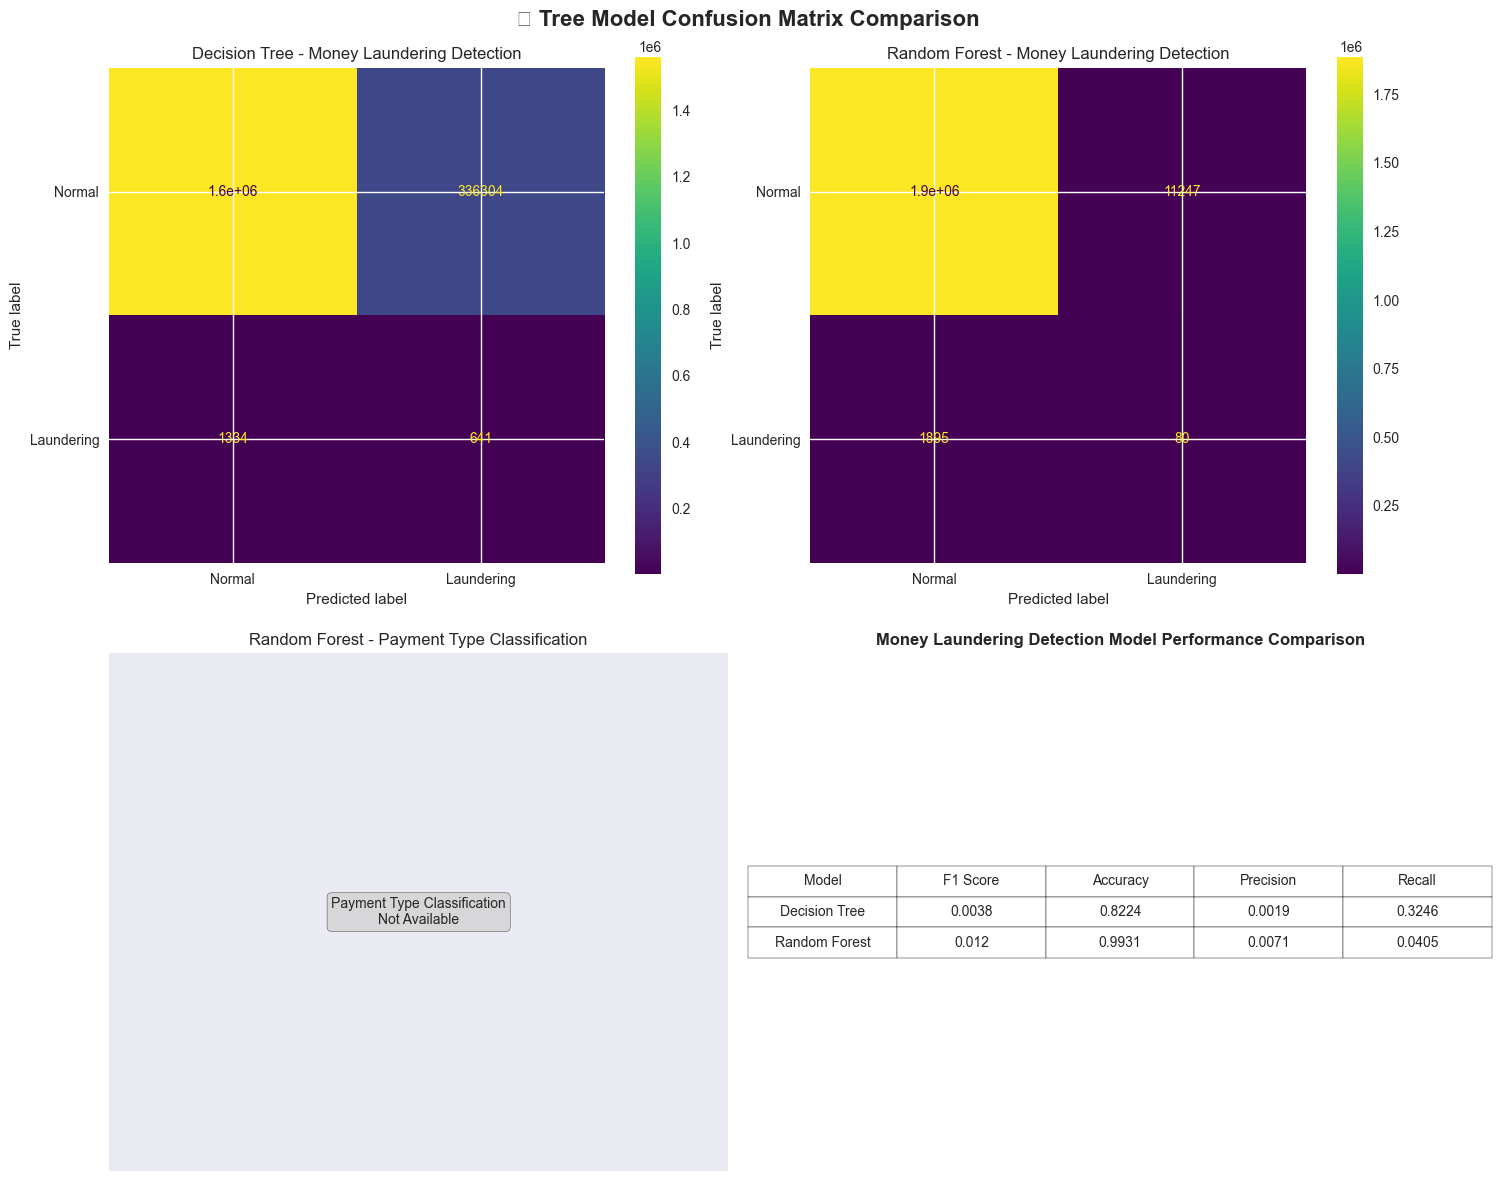


📊 Tree Model Performance Summary:
Decision Tree (Money Laundering Detection):
  ├─ F1 Score: 0.0038
  ├─ Accuracy: 0.8224
  ├─ Precision: 0.0019
  └─ Recall: 0.3246

Random Forest (Money Laundering Detection):
  ├─ F1 Score: 0.0120
  ├─ Accuracy: 0.9931
  ├─ Precision: 0.0071
  └─ Recall: 0.0405

🏆 Best Money Laundering Detection Model: Random Forest (Money Laundering Detection) (F1: 0.0120)
✅ Tree model evaluation completed!


In [ ]:
# 🌳 Tree Model Confusion Matrix Visualization and Performance Analysis
# This visualization displays the performance comparison of tree models

# Set up the visualization grid
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🌳 Tree Model Confusion Matrix Comparison', fontsize=16, fontweight='bold')

# Define correct key names
dt_key = 'Decision Tree (Money Laundering Detection)'
rf_key = 'Random Forest (Money Laundering Detection)'

# Money Laundering Detection - Decision Tree Confusion matrix
cm1 = confusion_matrix(tree_results[dt_key]['actual'],
                      tree_results[dt_key]['predictions'])
ConfusionMatrixDisplay(cm1, display_labels=['Normal', 'Laundering']).plot(ax=axes[0,0])
axes[0,0].set_title('Decision Tree - Money Laundering Detection')

# Money Laundering Detection - Random Forest Confusion matrix
cm2 = confusion_matrix(tree_results[rf_key]['actual'],
                      tree_results[rf_key]['predictions'])
ConfusionMatrixDisplay(cm2, display_labels=['Normal', 'Laundering']).plot(ax=axes[0,1])
axes[0,1].set_title('Random Forest - Money Laundering Detection')

# Payment Type Classification - Random Forest Confusion matrix (if available)
if 'tree_results_payment' in locals() and 'Random Forest (Payment Type)' in tree_results_payment:
    cm3 = confusion_matrix(tree_results_payment['Random Forest (Payment Type)']['actual'],
                          tree_results_payment['Random Forest (Payment Type)']['predictions'])
    ConfusionMatrixDisplay(cm3, display_labels=['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Type 5']).plot(ax=axes[1,0])
    axes[1,0].set_title('Random Forest - Payment Type Classification')
else:
    axes[1,0].text(0.5, 0.5, 'Payment Type Classification\nNot Available',
                   transform=axes[1,0].transAxes, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1,0].set_title('Random Forest - Payment Type Classification')
    axes[1,0].set_xticks([])
    axes[1,0].set_yticks([])

# Model Performance Comparison Table
comparison_data = {
    'Model': ['Decision Tree', 'Random Forest'],
    'F1 Score': [tree_results[dt_key]['f1'],
                tree_results[rf_key]['f1']],
    'Accuracy': [tree_results[dt_key]['accuracy'],
                tree_results[rf_key]['accuracy']],
    'Precision': [tree_results[dt_key]['precision'],
                 tree_results[rf_key]['precision']],
    'Recall': [tree_results[dt_key]['recall'],
              tree_results[rf_key]['recall']]
}

comparison_df = pd.DataFrame(comparison_data)

# Display comparison table in the fourth subplot
axes[1,1].axis('tight')
axes[1,1].axis('off')
table = axes[1,1].table(cellText=comparison_df.round(4).values,
                       colLabels=comparison_df.columns,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1,1].set_title('Money Laundering Detection Model Performance Comparison', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed Performance Summary
print("\n📊 Tree Model Performance Summary:")
print("="*50)
for name, result in tree_results.items():
    print(f"{name}:")
    print(f"  ├─ F1 Score: {result['f1']:.4f}")
    print(f"  ├─ Accuracy: {result['accuracy']:.4f}")
    print(f"  ├─ Precision: {result['precision']:.4f}")
    print(f"  └─ Recall: {result['recall']:.4f}")
    print()

# Find and highlight best model
best_model = max(tree_results.items(), key=lambda x: x[1]['f1'])
print(f"🏆 Best Money Laundering Detection Model: {best_model[0]} (F1: {best_model[1]['f1']:.4f})")
print("✅ Tree model evaluation completed!")


⏰ Time series data overview:
Time range: 2022-10-07 00:00:00 to 2023-08-23 00:00:00
Total days: 321 days

First 5 days data:
            transaction_count  total_amount  avg_amount  laundering_count  \
Date                                                                        
2022-10-07              20892  1.478376e+08     7076.28                27   
2022-10-08              29023  2.161697e+08     7448.22                29   
2022-10-09              28880  2.212059e+08     7659.48                32   
2022-10-10              27345  1.960082e+08     7167.97                32   
2022-10-11              28704  2.025634e+08     7056.97                30   

            laundering_rate  unique_senders  unique_receivers  
Date                                                           
2022-10-07              0.0            9110             11111  
2022-10-08              0.0           10072             13863  
2022-10-09              0.0           10300             13570  
2022-10-10     

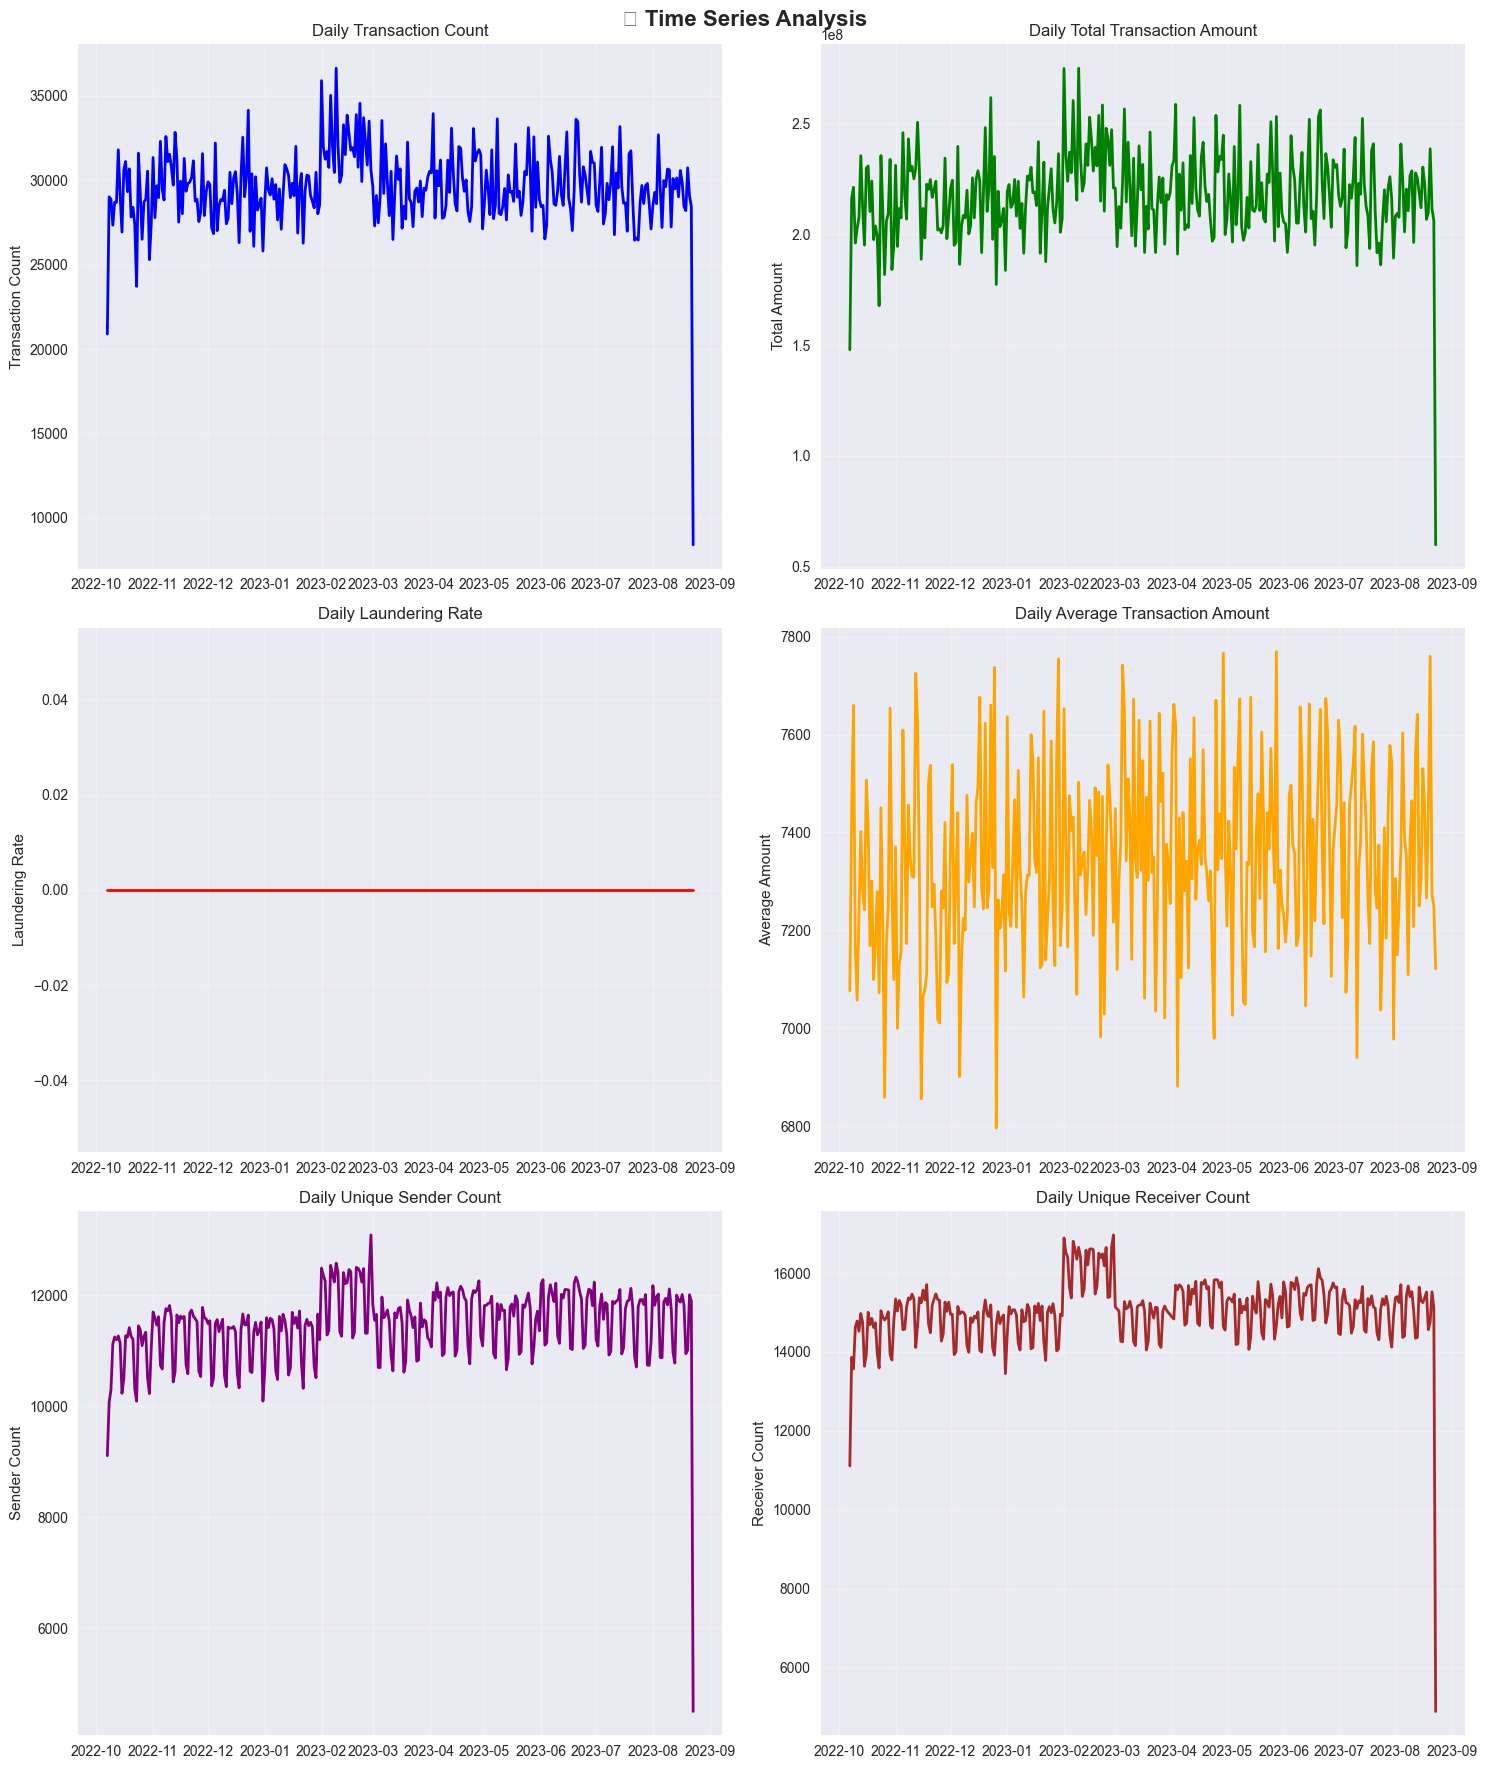

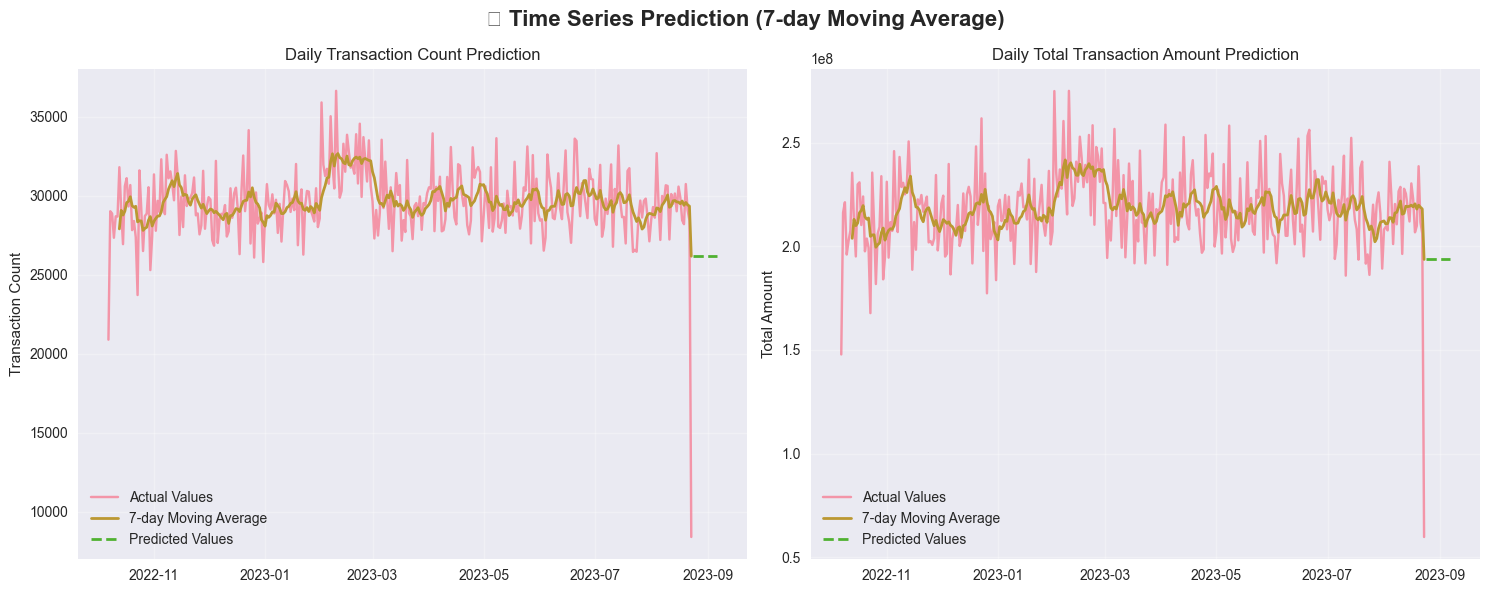

📈 Time Series Analysis Summary:
   Average daily transaction count: 29610
   Average daily transaction amount: 217647495
   Average laundering rate: 0.0000
   Predicted average transaction count for next 14 days: 26175
   Predicted average transaction amount for next 14 days: 193631691


In [ ]:
# ⏰ Time Series Analysis and Prediction
def create_time_series(df):
    """Create time series data"""
    # Ensure Date is in datetime format
    df_ts = df.copy()
    df_ts['Date'] = pd.to_datetime(df_ts['Date'])

    # Aggregate data by date
    daily_stats = df_ts.groupby('Date').agg({
        'Amount': ['count', 'sum', 'mean'],
        'Is_laundering': ['sum', 'mean'],
        'Sender_account': 'nunique',
        'Receiver_account': 'nunique'
    }).round(2)

    # Flatten column names
    daily_stats.columns = [
        'transaction_count', 'total_amount', 'avg_amount',
        'laundering_count', 'laundering_rate',
        'unique_senders', 'unique_receivers'
    ]

    return daily_stats

# Create time series data
ts_data = create_time_series(df_fe)

print("⏰ Time series data overview:")
print(f"Time range: {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Total days: {len(ts_data)} days")
print("\nFirst 5 days data:")
print(ts_data.head())

# Visualize time series
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('⏰ Time Series Analysis', fontsize=16, fontweight='bold')

# Daily transaction count
axes[0,0].plot(ts_data.index, ts_data['transaction_count'], linewidth=2, color='blue')
axes[0,0].set_title('Daily Transaction Count')
axes[0,0].set_ylabel('Transaction Count')
axes[0,0].grid(True, alpha=0.3)

# Daily transaction amount
axes[0,1].plot(ts_data.index, ts_data['total_amount'], linewidth=2, color='green')
axes[0,1].set_title('Daily Total Transaction Amount')
axes[0,1].set_ylabel('Total Amount')
axes[0,1].grid(True, alpha=0.3)

# Daily laundering rate
axes[1,0].plot(ts_data.index, ts_data['laundering_rate'], linewidth=2, color='red')
axes[1,0].set_title('Daily Laundering Rate')
axes[1,0].set_ylabel('Laundering Rate')
axes[1,0].grid(True, alpha=0.3)

# Daily average transaction amount
axes[1,1].plot(ts_data.index, ts_data['avg_amount'], linewidth=2, color='orange')
axes[1,1].set_title('Daily Average Transaction Amount')
axes[1,1].set_ylabel('Average Amount')
axes[1,1].grid(True, alpha=0.3)

# Unique sender count
axes[2,0].plot(ts_data.index, ts_data['unique_senders'], linewidth=2, color='purple')
axes[2,0].set_title('Daily Unique Sender Count')
axes[2,0].set_ylabel('Sender Count')
axes[2,0].grid(True, alpha=0.3)

# Unique receiver count
axes[2,1].plot(ts_data.index, ts_data['unique_receivers'], linewidth=2, color='brown')
axes[2,1].set_title('Daily Unique Receiver Count')
axes[2,1].set_ylabel('Receiver Count')
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Time series prediction (simple moving average)
def simple_forecast(series, window=7, periods=14):
    """Simple moving average prediction"""
    moving_avg = series.rolling(window=window).mean()
    last_avg = moving_avg.iloc[-1]

    # Generate future dates
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)

    # Simple prediction (using last moving average value)
    forecast = pd.Series([last_avg] * periods, index=future_dates)

    return moving_avg, forecast

# Predict transaction count
ma_count, forecast_count = simple_forecast(ts_data['transaction_count'])
ma_amount, forecast_amount = simple_forecast(ts_data['total_amount'])

# Visualize prediction results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('⏰ Time Series Prediction (7-day Moving Average)', fontsize=16, fontweight='bold')

# Transaction count prediction
axes[0].plot(ts_data.index, ts_data['transaction_count'], label='Actual Values', alpha=0.7)
axes[0].plot(ma_count.index, ma_count, label='7-day Moving Average', linewidth=2)
axes[0].plot(forecast_count.index, forecast_count, label='Predicted Values', linewidth=2, linestyle='--')
axes[0].set_title('Daily Transaction Count Prediction')
axes[0].set_ylabel('Transaction Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Transaction amount prediction
axes[1].plot(ts_data.index, ts_data['total_amount'], label='Actual Values', alpha=0.7)
axes[1].plot(ma_amount.index, ma_amount, label='7-day Moving Average', linewidth=2)
axes[1].plot(forecast_amount.index, forecast_amount, label='Predicted Values', linewidth=2, linestyle='--')
axes[1].set_title('Daily Total Transaction Amount Prediction')
axes[1].set_ylabel('Total Amount')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Time Series Analysis Summary:")
print(f"   Average daily transaction count: {ts_data['transaction_count'].mean():.0f}")
print(f"   Average daily transaction amount: {ts_data['total_amount'].mean():.0f}")
print(f"   Average laundering rate: {ts_data['laundering_rate'].mean():.4f}")
print(f"   Predicted average transaction count for next 14 days: {forecast_count.mean():.0f}")
print(f"   Predicted average transaction amount for next 14 days: {forecast_amount.mean():.0f}")


📊 Comprehensive Model Performance Comparison Table:
                  Task Type                                 Model Name Key Metric Performance Value                         Use Case
      Regression Prediction                          Linear (Original)         R²            0.0075        Basic linear relationship
      Regression Prediction                        Linear (Log Target)         R²           -0.2607           Skewed data processing
      Regression Prediction                      Polynomial (Degree=2)         R²            0.0053     Feature interaction modeling
      Regression Prediction                  Random Forest (Optimized)         R²            0.0645  Non-linear relationship capture
 Money Laundering Detection                        Logistic Regression   F1 Score            0.0120            High interpretability
 Money Laundering Detection Decision Tree (Money Laundering Detection)   F1 Score            0.0038            High interpretability
 Money Laundering

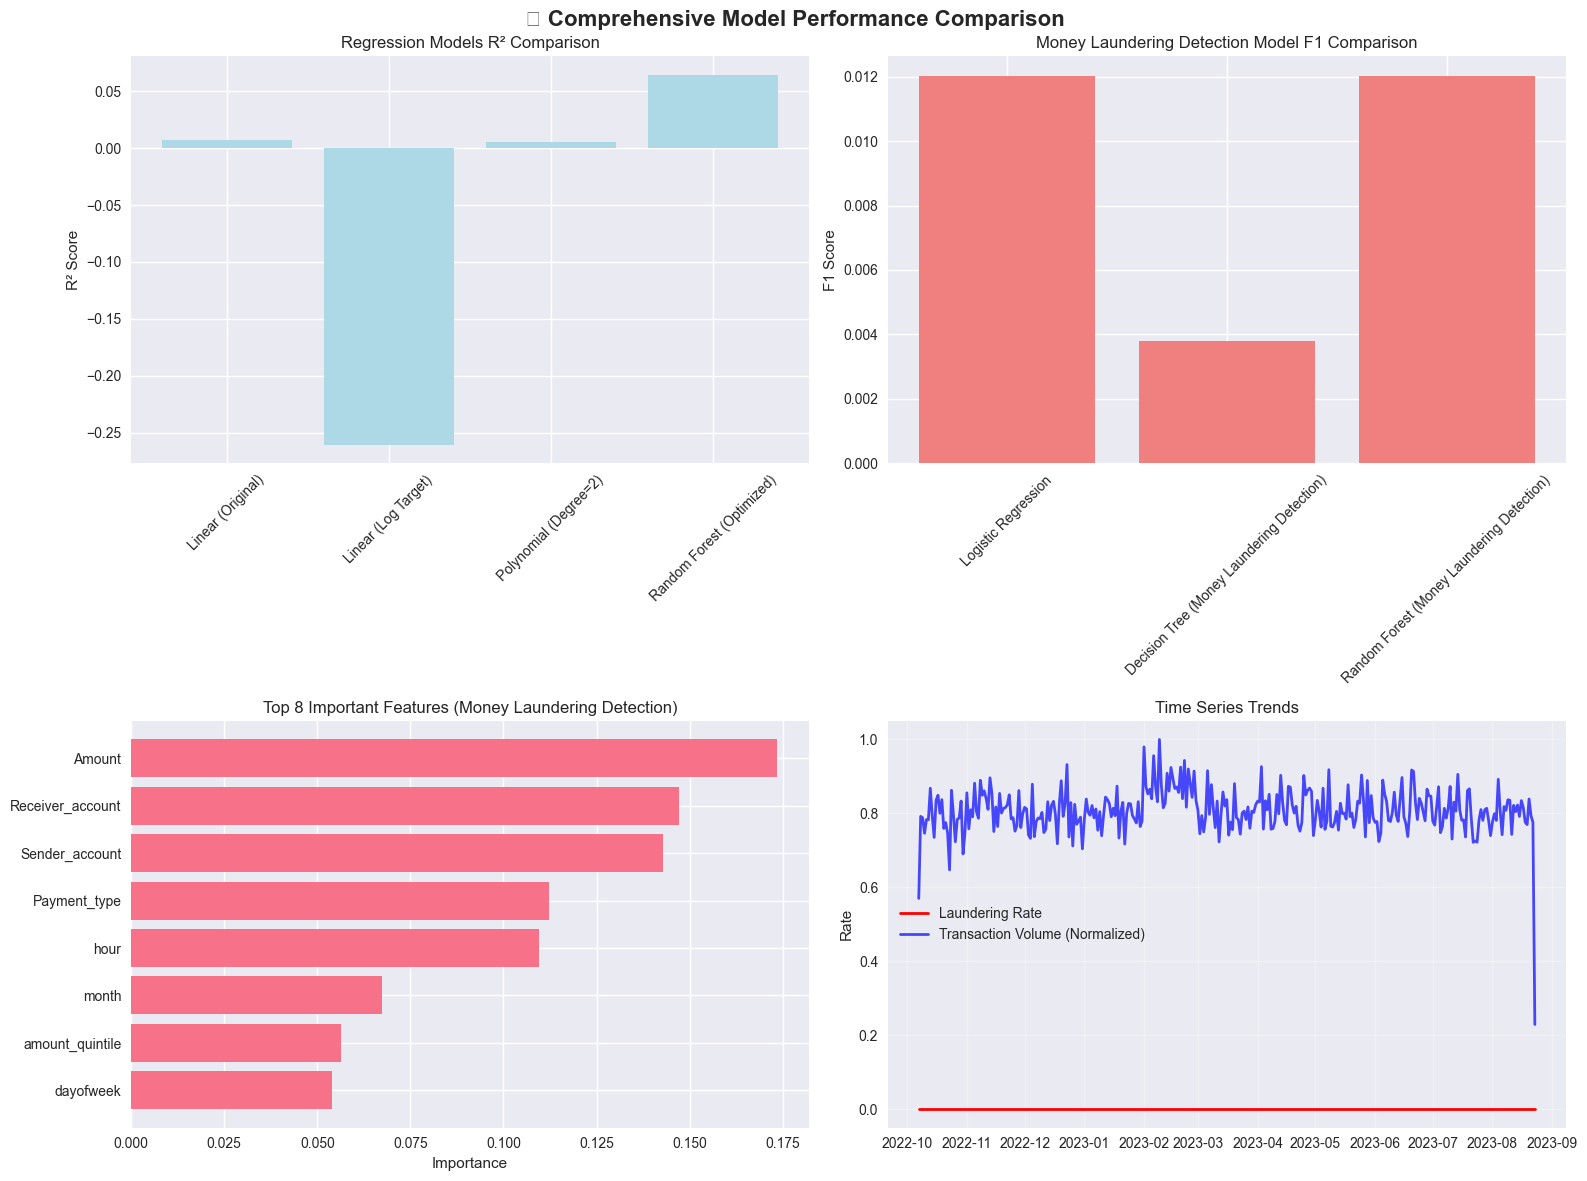


🎯 Business Recommendation Summary:
💡 Model Selection Recommendations:
   📈 Transaction Amount Prediction: Random Forest (Optimized) (R² = 0.0645)
   🎯 Money Laundering Detection: Random Forest (Money Laundering Detection) (F1 = 0.0120)
   📊 Payment Type Classification: Random Forest (Accuracy = 0.2118)

🔍 Key Findings:
   • Most important feature for Money Laundering Detection: Amount
   • Dataset characteristics: Contains 9,873 laundering cases (ratio 0.1039%)
   • Challenge: Extremely imbalanced dataset requiring specialized handling methods
   • Data quality: Payment currency and geographic distribution highly uneven, needs focused attention

🚀 Implementation Recommendations:
   1. Deploy Random Forest model for real-time money laundering detection
   2. Use Logistic Regression as interpretability supplement model
   3. Establish time series monitoring system to track abnormal trends
   4. Focus monitoring on non-mainstream currencies and regions
   5. Regularly retrain models to a

In [ ]:
# 📊 Comprehensive Model Performance Comparison and Summary

# Summarize all model performance
model_summary = {
    'Task Type': [],
    'Model Name': [],
    'Key Metric': [],
    'Performance Value': [],
    'Use Case': []
}

# Regression task results
for name, result in results.items():
    model_summary['Task Type'].append('Regression Prediction')
    model_summary['Model Name'].append(name)
    model_summary['Key Metric'].append('R²')
    model_summary['Performance Value'].append(f"{result['R²']:.4f}")
    if 'Random Forest' in name:
        model_summary['Use Case'].append('Non-linear relationship capture')
    elif 'Log' in name:
        model_summary['Use Case'].append('Skewed data processing')
    elif 'Polynomial' in name:
        model_summary['Use Case'].append('Feature interaction modeling')
    else:
        model_summary['Use Case'].append('Basic linear relationship')

# Classification task results
# Logistic Regression
model_summary['Task Type'].append('Money Laundering Detection')
model_summary['Model Name'].append('Logistic Regression')
model_summary['Key Metric'].append('F1 Score')
model_summary['Performance Value'].append(f"{f1:.4f}")
model_summary['Use Case'].append('High interpretability')

# Tree model results
for name, result in tree_results.items():
    model_summary['Task Type'].append('Money Laundering Detection')
    model_summary['Model Name'].append(name)
    model_summary['Key Metric'].append('F1 Score')
    model_summary['Performance Value'].append(f"{result['f1']:.4f}")
    if 'Decision Tree' in name:
        model_summary['Use Case'].append('High interpretability')
    else:
        model_summary['Use Case'].append('High accuracy, feature selection')

# Payment type classification
model_summary['Task Type'].append('Payment Type Classification')
model_summary['Model Name'].append('Random Forest')
model_summary['Key Metric'].append('Accuracy')
model_summary['Performance Value'].append(f"{accuracy_pay:.4f}")
model_summary['Use Case'].append('Multi-class classification')

# Create performance summary table
summary_df = pd.DataFrame(model_summary)

print("📊 Comprehensive Model Performance Comparison Table:")
print("="*80)
print(summary_df.to_string(index=False))

# Visualize model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')

# Regression models R² comparison
regression_models = [name for name in results.keys()]
regression_r2 = [results[name]['R²'] for name in regression_models]
axes[0,0].bar(regression_models, regression_r2, color='lightblue')
axes[0,0].set_title('Regression Models R² Comparison')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)

# Money Laundering Detection Model F1 comparison
laundering_models = ['Logistic Regression'] + list(tree_results.keys())
laundering_f1 = [f1] + [tree_results[name]['f1'] for name in tree_results.keys()]
axes[0,1].bar(laundering_models, laundering_f1, color='lightcoral')
axes[0,1].set_title('Money Laundering Detection Model F1 Comparison')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].tick_params(axis='x', rotation=45)

# Feature importance comparison (using Random Forest results)
rf_importance = pd.DataFrame({
    'feature': X_tree.columns,
    'importance': rf_laundering.feature_importances_
}).sort_values('importance', ascending=True).tail(8)

axes[1,0].barh(rf_importance['feature'], rf_importance['importance'])
axes[1,0].set_title('Top 8 Important Features (Money Laundering Detection)')
axes[1,0].set_xlabel('Importance')

# Time series trends
axes[1,1].plot(ts_data.index, ts_data['laundering_rate'], linewidth=2, color='red', label='Laundering Rate')
axes[1,1].plot(ts_data.index, ts_data['transaction_count']/ts_data['transaction_count'].max(),
               linewidth=2, color='blue', label='Transaction Volume (Normalized)', alpha=0.7)
axes[1,1].set_title('Time Series Trends')
axes[1,1].set_ylabel('Rate')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Business Recommendation Summary
print("\n🎯 Business Recommendation Summary:")
print("="*80)
print("💡 Model Selection Recommendations:")

# Find best models
best_regression = max(results.items(), key=lambda x: x[1]['R²'])
best_classification = max(tree_results.items(), key=lambda x: x[1]['f1'])
actual_laundering_count = df_fe['Is_laundering'].sum()
total_transactions = len(df_fe)
actual_laundering_rate = actual_laundering_count / total_transactions

print(f"   📈 Transaction Amount Prediction: {best_regression[0]} (R² = {best_regression[1]['R²']:.4f})")
print(f"   🎯 Money Laundering Detection: {best_classification[0]} (F1 = {best_classification[1]['f1']:.4f})")
print(f"   📊 Payment Type Classification: Random Forest (Accuracy = {accuracy_pay:.4f})")

print("\n🔍 Key Findings:")
print(f"   • Most important feature for Money Laundering Detection: {rf_importance.iloc[-1]['feature']}")
print(f"   • Dataset characteristics: Contains {actual_laundering_count:,} laundering cases (ratio {actual_laundering_rate:.4%})")
print(f"   • Challenge: Extremely imbalanced dataset requiring specialized handling methods")
print(f"   • Data quality: Payment currency and geographic distribution highly uneven, needs focused attention")

print("\n🚀 Implementation Recommendations:")
print("   1. Deploy Random Forest model for real-time money laundering detection")
print("   2. Use Logistic Regression as interpretability supplement model")
print("   3. Establish time series monitoring system to track abnormal trends")
print("   4. Focus monitoring on non-mainstream currencies and regions")
print("   5. Regularly retrain models to adapt to new laundering patterns")
